In [207]:
# importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch import flatten #flatten the image before the FC layers. Can reshape array too!
from sklearn.metrics import classification_report #for detailed statistics on classifier
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST #importing the MNIST Dataset already there on torch
from tqdm import tqdm 
from torchvision import transforms #for transforming the training and testing data 
from torch.utils.data import DataLoader #Dataloader loads the data batchwise with shuffling in a hassle free manner
from torch.optim import Adam #Adam for GD
import time # to see how long training took
from torchvision.utils import make_grid #to visualize the kernels the tensors
from torch.autograd import Variable #For the adversarial examples part to find the gradients



In [8]:
#Defining a class with the required CNN architecture

class CNN(nn.Module): #nn.Module helps us build our model as a class making it easy to reuse variables
    
    def __init__(self): #class constructor
        super(CNN,self).__init__() #calls the parent constructor
        
        #initializing first set of layers: CONV 32 filters 3x3 with padding = 1 + ReLU activation + 2x2 Max Pooling with Stride 2
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))) #nn.Sequential is a wrapper which combines all these together
        
        #initializing second set of layers: CONV 32 filters 3x3 with padding = 1 + RelU activation + 2x2 Max Pooling with Stride 2
        self.layer2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
        #initializing final set of layers: The fully connected part [500,10] 
        
        self.fc_layer1 = nn.Sequential(nn.Linear(7*7*32, 500),nn.ReLU()) #first fully connected layer
        self.fc_layer2 = nn.Linear(500,10)
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
        
    
    def forward(self,x): #defines the structure of the network thus help in performing backprop, it does forward pass
        
        output = self.layer1(x.float()) #converting x to float datatype
        output = self.layer2(output)
        output = flatten(output,1)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        
        pred   = self.logsoftmax(output)
        
        return pred
    
class CNN_with_Batch_Norm(nn.Module): #CNN but with Batch Normalization 
    
    def __init__(self): #class constructor
        super(CNN_with_Batch_Norm,self).__init__() #calls the parent constructor
        
        #initializing first set of layers: CONV 32 filters 3x3 with padding = 1 + ReLU activation + 2x2 Max Pooling with Stride 2
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),nn.BatchNorm2d(32)) #nn.Sequential is a wrapper which combines all these together
        
        #initializing second set of layers: CONV 32 filters 3x3 with padding = 1 + RelU activation + 2x2 Max Pooling with Stride 2
        self.layer2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        
        #initializing final set of layers: The fully connected part [500,10] 
        
        self.fc_layer1 = nn.Sequential(nn.Linear(7*7*32, 500),nn.ReLU(),nn.BatchNorm1d(500)) #first fully connected layer
        self.fc_layer2 = nn.Linear(500,10)
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
        
    
    def forward(self,x): #defines the structure of the network thus help in performing backprop, it does forward pass
        
        output = self.layer1(x.float()) #converting x to float datatype
        output = self.layer2(output)
        output = flatten(output,1)
        output = self.fc_layer1(output)
        output = self.fc_layer2(output)
        
        pred   = self.logsoftmax(output)
        
        return pred

In [347]:
# Flags for running various parts of the assignment

download_flag = False
load_model    = True
batch_norm    = False #Make it true when running Batch_Norm CNN
master_dir = os.getcwd() #this is the directory we're working in
mnist_dir     = 'mnist_A2' #directory to store the MNIST dataset
model_dir     = 'model' #directory containing the CNN model
return_lists  = True

#For Adversarial Examples
adv_iter      = 1500 #no of iterations for Gradient Ascent 15000 for NT 1000 for T 1000 for noise
step_size     = 0.05 #for gradient ascent very low for noise and NT decently large for T
beta          = 0.00001

if not os.path.exists(os.path.join(master_dir, mnist_dir)):
        os.mkdir(os.path.join(master_dir, mnist_dir)) #make the directory if it doesn't exist

if not os.path.exists(os.path.join(master_dir, model_dir)):
        os.mkdir(os.path.join(master_dir, model_dir)) #make the directory if it doesn't exist
model_path = os.path.join(master_dir, model_dir)+'/'


In [317]:
#Function to train the CNN 

#Training Hyperparams:
learning_rate = 1e-3
batch_size    = 64
N_epochs      = 10


#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #checks for gpu else runs in cpu


#Defining a function to train the network: Returns the training loss and training accuracy for the current epoch 
def Train(model,device,TrainDataLoader,optimizer,lossfn,train_length):  
    
    model.train() #setting the model in training mode
    
    #initializing the total training loss and total correct training predictions to 0
    train_loss    = 0
    train_correct = 0 #correct predictions made
     
    #loop over the training set
    
    for (data,label) in tqdm(TrainDataLoader):  # (data,label): Training data for that batch
        
        (data,label) = (data.to(device),label.to(device))  #sending the data to the device we've chosen
        
        #perform forward pass and compute the loss
        
        pred = model(data) #our prediction
        loss = lossfn(pred,label) #loss 
        
        optimizer.zero_grad() #zeroing out the gradients before backprop
        loss.backward()       #backprop from the loss
        optimizer.step()      #updating the weights
        
        #Adding this loss to  training loss and computing correct predictions
        
        train_loss    += loss
        train_correct += (pred.argmax(1) == label).type(torch.float).sum().item() #our prediction with max probability is our label
        
        
    #Computing training accuracy 
    
    train_correct /= train_length #training accuracy 
    
    return train_loss, train_correct #returning loss and accuracy 


#Defining a function to test the network: Returns the test loss and prediction accuracy for the current epoch
def Test(model,device,TestDataLoader,lossfn,test_length):
    
    model.eval()  #setting the model in eval/test mode
    
    #initializing the total test loss and total correct test predictions to 0
    test_loss    = 0
    test_correct = 0 #correct predictions made
    
    #switching off the gradient for eval
    with torch.no_grad():
        
        #loop over the test set
        
        for (data,label) in TestDataLoader: # (data,label): Test data for that batch
            
            (data,label) = (data.to(device),label.to(device))  #sending the data to the device we've chosen
        
            #perform forward pass and compute the loss
        
            pred = model(data) #our prediction
            loss = lossfn(pred,label) #loss 
            
            #Adding this loss to  test loss and computing correct predictions
        
            test_loss    += loss
            test_correct += (pred.argmax(1) == label).type(torch.float).sum().item() #our prediction with max probability is our label
        
        
    #Computing prediction accuracy 
    
    test_correct /= test_length  #prediction accuracy 
    
    return test_loss, test_correct #returning loss and accuracy 


def Run_CNN():
    
    startTime = time.time()
    
    #applied transform first converts the data into a tensor then normalizes it.
    #0.1307 is the mean of the MNIST data set and 0.3081 is the standard deviation
    
    app_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    
    #organize the training and test data
    
    train_data    = MNIST(mnist_dir, train = True, download = download_flag, transform = app_transform) #getting training data
    test_data     = MNIST(mnist_dir, train = False, transform = app_transform)
    
    #initialize the dataloaders
    TrainDataLoader = DataLoader(train_data, batch_size = batch_size, shuffle = True ) 
    TestDataLoader  = DataLoader(test_data, batch_size = batch_size) 
    
    train_length  = len(TrainDataLoader.dataset) #no of training examples
    test_length   = len(TestDataLoader.dataset)  #no of testing cases
    
    #initialize the model
    if(batch_norm):
        model = CNN_with_Batch_Norm().to(device)
    else:
        model = CNN().to(device) #moves model to CPU or GPU based on device
    
    #initialize the optimizer
    optimizer = Adam(model.parameters(),lr = learning_rate) #using Adam for GD as its the fastest and state of the art
    
    #initialize the loss function
    lossfn    = nn.NLLLoss() #like a cross entropy loss function when we couple this with softmax
    
    if (load_model): #if the load_model flag is true, load the pre-trained model
            model.load_state_dict(torch.load(model_path+'CNN_normal.mdl'), strict=False)
            
            def random_plots(): #plots random images along with their predicted class label
    
                #data_ind = np.random.randint(0 , 9999, 5) #selects 5 random images from test set
                data_ind  = [6003,416,6754,1605,5055,7965,517,5551,7070,6420]

                for ind in data_ind: #make predictions for all these indices
                    
                    print(ind)

                    test_image = TestDataLoader.dataset.data[ind].clone()  #creates a copy of the test_image from the dataset
                
                    true_label = TestDataLoader.dataset[ind][1] #unpacks the true label from the data loader
                    #print(true_label)

                    with torch.no_grad():
                        if(device == torch.device("cuda")): #if we're working on a GPU
                            test_image = test_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

                        else:
                            test_image = test_image.reshape(1,1,28,28).float()
                        
                        #print(test_image)

                        #detach breaks the image from the computational graph layer of the tensor before converting it to numpy format

                        pred = model.forward(test_image).detach().cpu().numpy() #as it is a single image we directly run the forward pass

                        pred_class = np.argmax(pred) #predicted class
                
                        plt.imshow(test_image.detach().cpu().numpy().reshape(28,28)) #our test image
                        str_title = "Image with true label "+str(true_label)+" is predicted as: " + str(pred_class)
                        plt.title(str_title)
                        plt.show()

            
            def Plot_Filters(): #plots the filters at the first and second convolutional layers

                conv1_filter = model.layer1[0].weight.detach().clone() #creating a copy of the filter weights

                if(device == torch.device('cuda')):
                    conv1_filter = conv1_filter.cpu() #get it to the CPU
                    

                #normalizing the filters by scaling the values makes it stand out from the background
                conv1_filter -= conv1_filter.min() #subtracting a negative value will make the image stand out,makes it "whiter"
                conv1_filter /= conv1_filter.max() # there will be 32 such filters
                image         = make_grid(conv1_filter) #this returns a tensor grid containing the images
                #print(image.size()) 
                image         = image.permute(1,2,0) #permuting the dimensions of the tensor grid to make it right ie, 3x3x32
                #print(image.size())

                #plotting the first layer filters
                plt.imshow(image)
                plt.title('First Convolutional Layer Filters')
                plt.show()
                
            

                conv2_filter = model.layer2[0].weight.detach().clone() #creating a copy of the filter weights

                if(device == torch.device('cuda')):
                    conv2_filter = conv2_filter.cpu() #get it to the CPU

                #normalizing the filters by scaling the values this makes it stand out from the background
            
                conv2_filter -= conv2_filter.min()
                conv2_filter /= conv2_filter.max() # there will be 32 such block filters of dim 3x3x32
                #print(conv2_filter.size()) 

                #Therefore, using a random number generator to choose which block filters to plot
                filt_ind = np.random.randint(0 , 31, 5) #as we're gonna plot 5 such filters

                for ind in filt_ind:    

                    image         = make_grid(conv2_filter[ind].reshape(conv1_filter.size())) #this returns a tensor grid containing the images
                    image         = image.permute(1,2,0) #permuting the dimensions of the tensor grid to make it right 

                    #plotting the second layer filters
                    plt.imshow(image)
                    str_title = 'Second Convolutional Layer Filter no: ' + str(ind)
                    plt.title(str_title)
                    plt.show()
            
            

            def Visualize_activations(): #visualizes the output of the convolutional layer before the ReLU kicks in
    
                #choose data index at random
                data_ind = np.random.randint(0,9999)
                test_image = TestDataLoader.dataset.data[data_ind].clone()  #creates a copy of the test_image from the dataset


                with torch.no_grad():
                    if(device == torch.device("cuda")): #if we're working on a GPU
                        test_image = test_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

                    else:
                        test_image = test_image.reshape(1,1,28,28).float()

                    conv1_FM = model.layer1[0].forward(test_image).reshape(32,1,28,28) #we take the featuremaps obtained at the output of conv1

                    #normalizing the feature maps by scaling the values makes it stand out from the background
                    conv1_FM -= conv1_FM.min() #subtracting a negative value will make the image stand out,makes it "whiter"
                    conv1_FM /= conv1_FM.max() # there will be 32 such filters
                    image         = make_grid(conv1_FM) #this returns a tensor grid containing the images         
                    image         = image.permute(1,2,0) #permuting the dimensions of the tensor grid to make it right

                    #plotting the first layer feature maps
                    plt.imshow(image)
                    plt.title('Output Activations from the first Convolutional Layer')
                    plt.show()
                
                with torch.no_grad():

                    conv2_FM = model.layer1.forward(test_image)
                    conv2_FM = model.layer2[0].forward(conv2_FM).reshape(32,1,14,14) #we take the featuremaps obtained at the output of conv2

                    #normalizing the feature maps by scaling the values makes it stand out from the background
                    conv2_FM -= conv2_FM.min() #subtracting a negative value will make the image stand out,makes it "whiter"
                    conv2_FM /= conv2_FM.max() # there will be 32 such filters
                    image         = make_grid(conv2_FM) #this returns a tensor grid containing the images         
                    image         = image.permute(1,2,0) #permuting the dimensions of the tensor grid to make it right

                    #plotting the second layer feature maps
                    plt.imshow(image)
                    plt.title('Output Activations from the second Convolutional Layer')
                    plt.show()
    
            #initializing number list which will be useful in the upcoming experiments
            number_list = [6003,416,6754,1605,5055,7965,517,5551,7070,6420] #indices where the digits 0 through 9 are found
            def Occlusion_Exp(): #perform the occlusion experiment
    
                patch_size = int(10)
                stride     = int(2)
                dim        = int((28-patch_size)/stride + 1) #28 is W,H input
                #perform the occlusion experiment for all the digits

                data_ind = number_list #initializing the data indices 

                for j in range(len(data_ind)):
                    ind = data_ind[j]
                    i = 1 #a dummy counter
                    test_image = TestDataLoader.dataset.data[ind].clone()  #creates a copy of the test_image from the dataset
                    true_label = TestDataLoader.dataset[ind][1] #unpacks the true label from the data loader

                    probability_matrix = np.zeros((dim,dim), dtype = np.float) #changing the dtype here itself so we don't have to change later
                    predicted_class    = np.zeros(probability_matrix.shape) #the class NN predicts for every step of the occlusion experiment

                    for y in range(0,(28-patch_size)+1,stride):
                        for x in range(0,(28-patch_size)+1,stride): #move along x first for every y
                            occl_image = test_image.clone() #clone the test image for occlusion every time

                            #portion of the image to be covered
                            occl_image[x:x+patch_size,y:y+patch_size] = 0 #put a black patch there

                            #perform the forward pass and obtain the probability
                            with torch.no_grad():
                                    if(device == torch.device("cuda")): #if we're working on a GPU
                                        occl_image = occl_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

                                    else:
                                        occl_image = occl_image.reshape(1,1,28,28).float()

                                    #print(test_image)

                                    #detach breaks the image from the computational graph layer of the tensor before converting it to numpy format

                                    pred = model.forward(occl_image).detach().cpu().numpy() #as it is a single image we directly run the forward pass
                                    pred_class = np.argmax(pred) #predicted class

                                    #pred is in the form of log_softmax and therefore, we take an exponent to convert them to probability
                                    pred = np.exp(pred) #now in the form of probabilities

                                    probability_matrix[int(y/stride),int(x/stride)] = pred[:,j] #assigning the probability of true class
                                    predicted_class[int(y/stride),int(x/stride)]    = pred_class

                                    if(ind == data_ind[0]): #plotting the occlusion experiment just for 0
                                        plt.subplot(dim,dim,i)
                                        i += 1
                                        plt.imshow(occl_image.cpu().numpy().reshape(28,28)) #our occluded image

                    plt.suptitle("Occlusion Experiment for 0",x = 0.5,y=1.1)
                    plt.tight_layout()
                    plt.show()


                    #Plot of the probability matrix       
                    plt.imshow(probability_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
                    plt.colorbar()
                    plt.title('Probability Grid for digit: '+str(j))
                    plt.ylabel('Y Patch position')
                    plt.xlabel('X Patch position')
                    plt.show()

                    #Plot of the Predicted Class
                    print(predicted_class)
                    #print(probability_matrix)
            
            # Adversarial Examples

            def Non_Targeted_Attack(): #keeps changing the noise till it resembles some class



                for j in range(10): # j takes the values from 0 to 9

                    target_class = j #target class
                    noise        = np.random.normal(loc = 128, scale = 8, size = (28,28)).reshape(1,1,28,28) #centred around 128 with standard deviation 8
                    noise        = torch.from_numpy(noise)

                    if(device == torch.device('cuda')): #GPU
                        noise_tensor =  torch.tensor(noise.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda') #converting to a tensor with appropriate dimensions
                    else:
                        noise_tensor = torch.tensor(noise.type(torch.FloatTensor), requires_grad=True)


                    #calculating logit values : logit is the network output just before softmax
                    logit_cost = [] 

                    #using ADAM for gradient ascent
                    optim=torch.optim.Adam([noise_tensor], lr=step_size)

                    for i in range(adv_iter):
                        optim.zero_grad()


                        #we don't switch gradient off here as it is required
                        #forward pass
                        output = model.layer1.forward(noise_tensor)
                        output = model.layer2.forward(output)
                        output = flatten(output,1)
                        output = model.fc_layer1.forward(output)
                        logit  = model.fc_layer2.forward(output)
                        loss   = -logit[:,target_class] #to convert Gradient Descent to a Gradient Ascent

                        logit_cost.append(logit[:,target_class].cpu().detach().numpy())

                        loss.backward(retain_graph = True)

                        optim.step()


                    plt.plot(np.asfarray(logit_cost))
                    plt.title('Cost Function for digit '+str(target_class))
                    plt.xlabel('<--iterations -->')
                    plt.ylabel('Loss')
                    plt.grid()
                    plt.show()

                    #normalization
                    NT_plot = noise_tensor.cpu().reshape(28,28).detach().numpy()
                    NT_plot = NT_plot - np.min(NT_plot)
                    NT_plot = NT_plot/np.max(NT_plot)

                    plt.imshow(NT_plot,cmap = plt.cm.Wistia)
                    plt.colorbar()
                    plt.title("Non Targeted Image for "+str(target_class))
                    plt.show()
        
            
            def Targeted_Attack(): #convert image of one class to look like image of another
    
                #we can let the user choose the set of original image and target classes

                orig_class = int(input("Enter the digit you'd want the generated image to look like"))
                target_class = int(input("What digit would you want this image to be recognized as?"))

                target_image = TestDataLoader.dataset.data[number_list[orig_class]].clone() #taking the image corresponding the orig image as our target image

                if(device == torch.device("cuda")): #if we're working on a GPU
                    target_image = target_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

                else:
                    target_image = target_image.reshape(1,1,28,28).float()


                #plotting the target image
                fig, axs = plt.subplots(1, 2,figsize = (8,8)) #plotting the target image and generated image side by side

                axs[0].imshow(target_image.detach().cpu().numpy().reshape(28,28)) #our target image
                axs[0].set_title("Target image with true label "+str(orig_class))

                #we initialize X with the target image itself for faster convergence 
                X = target_image.detach().cpu().clone() 

                if(device == torch.device('cuda')): #GPU
                    X_tensor =  torch.tensor(X.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda') #converting to a tensor with appropriate dimensions
                else:
                    X_tensor = torch.tensor(X.type(torch.FloatTensor), requires_grad=True)



                #using ADAM for gradient ascent
                optim=torch.optim.Adam([X_tensor], lr=step_size)
                mse_loss = nn.MSELoss()

                for i in range(adv_iter):
                    optim.zero_grad()


                    #we don't switch gradient off here as it is required
                    #forward pass
                    output = model.layer1.forward(X_tensor)
                    output = model.layer2.forward(output)
                    output = flatten(output,1)
                    output = model.fc_layer1.forward(output)
                    logit  = model.fc_layer2.forward(output)

                    logit_cost = -logit[:,target_class] #the loss component pertaining to the logits , taking negative of this as we wanna perform gradient ascent
                    mse_cost   = beta*mse_loss(X_tensor,target_image) #mse loss b/w noise and target image
                    t_loss       = logit_cost + mse_cost

                    t_loss.backward(retain_graph = True)
                    optim.step()

                #after all the iterations, find the confidence with which it classifies
                pred = model.forward(X_tensor).detach().cpu().numpy() #as it is a single image we directly run the forward pass
                pred_class = np.argmax(pred) #predicted class
                print(pred_class)

                #pred is in the form of log_softmax and therefore, we take an exponent to convert them to probability
                confidence = np.exp(pred)[:,target_class] #now in the form of probabilities

                print('Confidence in prediction:', confidence)

                #normalization
                NT_plot = X_tensor.cpu().reshape(28,28).detach().numpy()
                NT_plot = NT_plot - np.min(NT_plot)
                NT_plot = NT_plot/np.max(NT_plot)

                axs[1].imshow(NT_plot)
                axs[1].set_title("Targeted Image for "+str(target_class))

                # Hide x labels and tick labels for top plots and y ticks for right plots.
                for ax in axs.flat:
                    ax.label_outer()

                fig.suptitle("Comparing the true image and the generated image for Targeted Attack ",x = 0.5,y=0.8)
                fig.tight_layout()
                fig.show()
                
            
            #create noise matrices which are later added to other images and see if the predicted label changes
            def adding_noise(): #add noise to an image update it and make it look like another image

                #we can let the user choose the set of original image and target classes

                orig_class = int(input("Enter the digit you'd want the generated image to look like"))
                target_class = int(input("What digit would you want this image to be recognized as?"))

                orig_image = TestDataLoader.dataset.data[number_list[orig_class]].clone() 

                if(device == torch.device("cuda")): #if we're working on a GPU
                    orig_image = orig_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

                else:
                    orig_image = orig_image.reshape(1,1,28,28).float()

                fig,axs = plt.subplots(1,5,figsize = (20,20))

                #plotting the original image
                axs[0].imshow(orig_image.detach().cpu().numpy().reshape(28,28)) #our original image
                axs[0].set_title("Original image with true label "+str(orig_class))

                noise = np.zeros((1,1,28,28),dtype = np.float) #initializing noise matrix
                noise = torch.from_numpy(noise)

                #convert the noise into a tensor enabling gradient
                if(device == torch.device('cuda')): #GPU
                    noise_tensor =  torch.tensor(noise.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda') #converting to a tensor with appropriate dimensions
                else:
                    noise_tensor = torch.tensor(noise.type(torch.FloatTensor), requires_grad=True)



                #using ADAM for gradient ascent
                optim=torch.optim.Adam([noise_tensor], lr=step_size)
                for i in range(adv_iter):
                    X = orig_image + noise_tensor

                    optim.zero_grad()
                    #we don't switch gradient off here as it is required
                    #forward pass
                    output = model.layer1.forward(X)
                    output = model.layer2.forward(output)
                    output = flatten(output,1)
                    output = model.fc_layer1.forward(output)
                    logit  = model.fc_layer2.forward(output)

                    n_logit_cost = -logit[:,target_class] #the loss component pertaining to the logits , taking negative of this as we wanna perform gradient ascent
                    n_logit_cost.backward(retain_graph = True)

                    optim.step() #gradient ascent wrt noise this time

                #after all the iterations, find the confidence with which it classifies
                X = orig_image + noise_tensor
                pred = model.forward(X).detach().cpu().numpy() #as it is a single image we directly run the forward pass
                pred_class = np.argmax(pred) #predicted class
                print('Predicted Class: ',pred_class)

                #pred is in the form of log_softmax and therefore, we take an exponent to convert them to probability
                confidence = np.exp(pred)[:,target_class] #now in the form of probabilities

                print('Confidence in prediction:', confidence)

                #normalization
                #plot for the noise added image
                NT_plot = X.cpu().reshape(28,28).detach().numpy()
                NT_plot = NT_plot - np.min(NT_plot)
                NT_plot = NT_plot/np.max(NT_plot)

                axs[1].imshow(NT_plot)
                axs[1].set_title("Noise Added Image for "+str(target_class))

                #plot for noise
                NT_plot = noise_tensor.cpu().reshape(28,28).detach().numpy()
                NT_plot = NT_plot - np.min(NT_plot)
                NT_plot = NT_plot/np.max(NT_plot)

                axs[2].imshow(NT_plot,vmin = 0,vmax = 1)
                axs[2].set_title("Noise Matrix for target class "+str(target_class))

                new_orig_class = int(input("Enter the digit you'd want to add the noise matrix to")) 

                new_orig_image = TestDataLoader.dataset.data[number_list[new_orig_class]].clone() 

                if(device == torch.device("cuda")): #if we're working on a GPU
                    new_orig_image = new_orig_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 pixels

                else:
                    new_orig_image = new_orig_image.reshape(1,1,28,28).float()

                X = new_orig_image + noise_tensor

                pred = model.forward(X).detach().cpu().numpy() #as it is a single image we directly run the forward pass
                pred_class = np.argmax(pred) #predicted class
                print('Predicted Class: ',pred_class)

                #pred is in the form of log_softmax and therefore, we take an exponent to convert them to probability
                confidence = np.exp(pred)[:,target_class] #now in the form of probabilities

                print('Confidence in prediction:', confidence)

                #normalization
                #plot for the noise added image
                NT_plot = X.cpu().reshape(28,28).detach().numpy()
                NT_plot = NT_plot - np.min(NT_plot)
                NT_plot = NT_plot/np.max(NT_plot)

                axs[4].imshow(NT_plot)
                axs[4].set_title("Noise Added Image predicted as  "+str(pred_class))

                #plot for new image
                axs[3].imshow(new_orig_image.detach().cpu().numpy().reshape(28,28)) #our original image
                axs[3].set_title("Original image with true label "+str(new_orig_class))

                # Hide x labels and tick labels for top plots and y ticks for right plots.
                for ax in axs.flat:
                    ax.label_outer()

                fig.suptitle("Noise Addition Experiment with target class: "+str(target_class),x = 0.5,y=0.7,fontsize = 20)
                fig.tight_layout()
                fig.show()

            ans = str(input("Do you wanna observe the plots of random test images and their corresponded predicted labels? (y/n)")).lower()
            if(ans == 'y'):
                random_plots()
            ans = str(input("Do you wanna observe the plots of the filters in the convolutional layers? (y/n)")).lower()
            if(ans == 'y'):
                Plot_Filters()
            ans = str(input("Do you wanna observe the plots of the activation functions of the convolutional layers? (y/n)")).lower()
            if(ans == 'y'):
                Visualize_activations()
            ans = str(input("Do you wanna partake in an occlusion experiment? (y/n)")).lower()
            if(ans == 'y'):
                Occlusion_Exp()
            ans = str(input("Do you wanna orchestrate a non targeted adversarial attack? (y/n)")).lower()
            if(ans == 'y'):
                Non_Targeted_Attack()
            ans = str(input("Do you wanna orchestrate a targeted adversarial attack? (y/n)")).lower()
            if(ans == 'y'):
                Targeted_Attack()
            ans = str(input("Do you wanna orchestrate a noise addition based adversarial attack? (y/n)")).lower()
            if(ans == 'y'):
                adding_noise()
                    
            
    else: #train and test the CNN network if load_model flag is false
        
        #initialising the lists
        
        train_losses   = []
        test_losses    = []
        train_accuracy = []
        test_accuracy  = []
        
        for epoch in range(1, N_epochs+1):
            print("Epoch ",epoch," has just begun!")
            print('****************** ', epoch/N_epochs," % ******************") #creates a status bar instead of using tqdm
            
            #train the model
            loss,accuracy = Train(model,device,TrainDataLoader,optimizer,lossfn,train_length)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            print('Train loss for Epoch ',epoch,': ',loss)
            print('Train accuracy for Epoch ',epoch, ': ',accuracy)
            
            #test the model
            loss,accuracy = Test(model,device,TestDataLoader,lossfn,test_length)
            test_losses.append(loss)
            test_accuracy.append(accuracy)
            print('Test loss for Epoch ',epoch,': ',loss)
            print('Test accuracy for Epoch ',epoch, ': ',accuracy)
            
        endTime = time.time()  
        print("Time taken to train and test model: ",endTime-startTime)
        print("Average prediction accuracy across epochs: ",np.mean(test_accuracy))
        print("Average training accuracy across epochs: ",np.mean(train_accuracy))
        
        #Plotting the Loss and the accuracy curves
        
        plt.plot(np.asfarray(train_losses),'o-',label = 'Train Loss') #converting to float array
        plt.plot(np.asfarray(test_losses),'o-',label = 'Validation Loss') 
        plt.xlabel('<-- Epochs -->')
        plt.ylabel('Normalized Loss')
        plt.grid()
        plt.legend()
        plt.title('Progress of Training and Validation error with every Epoch')
        plt.show()
            
        plt.plot(np.asfarray(train_accuracy),'o-',label = 'Training Accuracy')
        plt.plot(np.asfarray(test_accuracy),'o-',label = 'Testing Accuracy')
        plt.xlabel('<-- Epochs -->')
        plt.ylabel('Accuracy')
        plt.ylim(0,1) #as accuracy is between 0 and 1
        plt.grid()
        plt.legend()
        plt.title('Progress of Training and Prediction Accuracy with every Epoch')
        plt.show()
            
            
        #generating a classification report
            
        #final predictions
        
        preds = [] #list to store our final predictions
        
        #switching off the gradient for eval
        with torch.no_grad():
        
            #loop over the test set

            for (data,label) in TestDataLoader: # (data,label): Test data for that batch

                (data,label) = (data.to(device),label.to(device))  #sending the data to the device we've chosen

                #perform forward pass and compute the loss

                pred = model(data) #our prediction

                #add our predictions to the list
                preds.extend(pred.argmax(axis=1).cpu().numpy())
            
        print(classification_report(test_data.targets.cpu().numpy(), np.asfarray(preds), target_names=test_data.classes))
        
        
        #plotting the confusion matrix
        confusion_mat = confusion_matrix(test_data.targets.cpu().numpy(), np.asfarray(preds))
        
        plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Wistia)
        plt.colorbar()
        classNames = ['0','1','2','3','4','5','6','7','8','9']
        plt.title('Test Data: Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        tick_marks = np.arange(len(classNames))
        plt.xticks(tick_marks, classNames)
        plt.yticks(tick_marks, classNames)
        plt.show()
            
        # Save the model we just trained
        torch.save(model.state_dict(), model_path+'CNN_normal.mdl')
        
        if(return_lists):
            return np.asfarray(train_losses),np.asfarray(test_losses),np.asfarray(train_accuracy),np.asfarray(test_accuracy)

                    
            
            
            
        

    
    
    
    
    
    
     

            
            
    
    
    
    

    
    
    
    

C:\Users\ABHISHEK\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  0%|                                                                                          | 0/938 [00:00<?, ?it/s]C:\Users\ABHISHEK\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internal

Epoch  1  has just begun!
******************  0.1  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:43<00:00, 21.52it/s]


Train loss for Epoch  1 :  tensor(117.9607, grad_fn=<AddBackward0>)
Train accuracy for Epoch  1 :  0.9617333333333333


  0%|▏                                                                                 | 2/938 [00:00<00:48, 19.47it/s]

Test loss for Epoch  1 :  tensor(8.9523)
Test accuracy for Epoch  1 :  0.9832
Epoch  2  has just begun!
******************  0.2  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:46<00:00, 20.13it/s]


Train loss for Epoch  2 :  tensor(38.2086, grad_fn=<AddBackward0>)
Train accuracy for Epoch  2 :  0.9872


  0%|▏                                                                                 | 2/938 [00:00<00:48, 19.28it/s]

Test loss for Epoch  2 :  tensor(4.8583)
Test accuracy for Epoch  2 :  0.99
Epoch  3  has just begun!
******************  0.3  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:00<00:00, 15.38it/s]


Train loss for Epoch  3 :  tensor(25.7165, grad_fn=<AddBackward0>)
Train accuracy for Epoch  3 :  0.9911833333333333


  0%|▏                                                                                 | 2/938 [00:00<01:08, 13.71it/s]

Test loss for Epoch  3 :  tensor(7.4745)
Test accuracy for Epoch  3 :  0.9824
Epoch  4  has just begun!
******************  0.4  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:00<00:00, 15.52it/s]


Train loss for Epoch  4 :  tensor(18.1501, grad_fn=<AddBackward0>)
Train accuracy for Epoch  4 :  0.99385


  0%|▏                                                                                 | 2/938 [00:00<01:12, 12.94it/s]

Test loss for Epoch  4 :  tensor(6.3364)
Test accuracy for Epoch  4 :  0.9887
Epoch  5  has just begun!
******************  0.5  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:04<00:00, 14.64it/s]


Train loss for Epoch  5 :  tensor(15.6473, grad_fn=<AddBackward0>)
Train accuracy for Epoch  5 :  0.9942166666666666


  0%|▏                                                                                 | 2/938 [00:00<00:52, 17.75it/s]

Test loss for Epoch  5 :  tensor(5.6019)
Test accuracy for Epoch  5 :  0.9883
Epoch  6  has just begun!
******************  0.6  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:02<00:00, 15.12it/s]


Train loss for Epoch  6 :  tensor(10.8081, grad_fn=<AddBackward0>)
Train accuracy for Epoch  6 :  0.9964833333333334


  0%|                                                                                  | 1/938 [00:00<01:39,  9.46it/s]

Test loss for Epoch  6 :  tensor(6.4219)
Test accuracy for Epoch  6 :  0.9886
Epoch  7  has just begun!
******************  0.7  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:58<00:00, 16.14it/s]


Train loss for Epoch  7 :  tensor(9.6367, grad_fn=<AddBackward0>)
Train accuracy for Epoch  7 :  0.9967


  0%|▏                                                                                 | 2/938 [00:00<00:58, 16.04it/s]

Test loss for Epoch  7 :  tensor(4.4019)
Test accuracy for Epoch  7 :  0.9924
Epoch  8  has just begun!
******************  0.8  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:03<00:00, 14.75it/s]


Train loss for Epoch  8 :  tensor(9.1132, grad_fn=<AddBackward0>)
Train accuracy for Epoch  8 :  0.9968666666666667


  0%|▏                                                                                 | 2/938 [00:00<00:48, 19.28it/s]

Test loss for Epoch  8 :  tensor(6.5983)
Test accuracy for Epoch  8 :  0.9895
Epoch  9  has just begun!
******************  0.9  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:12<00:00, 12.91it/s]


Train loss for Epoch  9 :  tensor(6.6993, grad_fn=<AddBackward0>)
Train accuracy for Epoch  9 :  0.9977333333333334


  0%|▏                                                                                 | 2/938 [00:00<00:52, 17.75it/s]

Test loss for Epoch  9 :  tensor(7.0426)
Test accuracy for Epoch  9 :  0.9878
Epoch  10  has just begun!
******************  1.0  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:57<00:00, 16.21it/s]


Train loss for Epoch  10 :  tensor(6.7729, grad_fn=<AddBackward0>)
Train accuracy for Epoch  10 :  0.9977833333333334
Test loss for Epoch  10 :  tensor(6.4401)
Test accuracy for Epoch  10 :  0.9891
Time taken to train and test model:  636.1789393424988


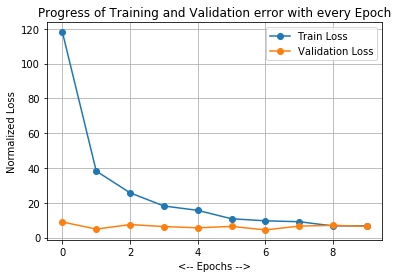

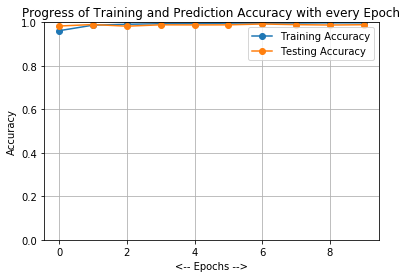

              precision    recall  f1-score   support

    0 - zero       1.00      0.99      0.99       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.96      1.00      0.98      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       1.00      0.97      0.98       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       1.00      0.99      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



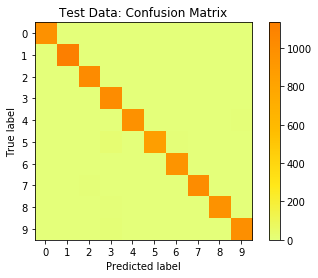

In [5]:
#CNN run without Batch Normalization
train_loss,test_loss,train_acc,test_acc = Run_CNN()

  0%|▎                                                                                 | 3/938 [00:00<00:39, 23.97it/s]

Epoch  1  has just begun!
******************  0.1  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:44<00:00, 20.97it/s]


Train loss for Epoch  1 :  tensor(117.0639, grad_fn=<AddBackward0>)
Train accuracy for Epoch  1 :  0.9607333333333333


  0%|▏                                                                                 | 2/938 [00:00<00:47, 19.59it/s]

Test loss for Epoch  1 :  tensor(6.7513)
Test accuracy for Epoch  1 :  0.9862
Epoch  2  has just begun!
******************  0.2  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:43<00:00, 21.37it/s]


Train loss for Epoch  2 :  tensor(38.2184, grad_fn=<AddBackward0>)
Train accuracy for Epoch  2 :  0.9871333333333333


  0%|▏                                                                                 | 2/938 [00:00<00:50, 18.67it/s]

Test loss for Epoch  2 :  tensor(5.7878)
Test accuracy for Epoch  2 :  0.9879
Epoch  3  has just begun!
******************  0.3  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:44<00:00, 20.99it/s]


Train loss for Epoch  3 :  tensor(26.4859, grad_fn=<AddBackward0>)
Train accuracy for Epoch  3 :  0.9912


  0%|▏                                                                                 | 2/938 [00:00<00:49, 19.06it/s]

Test loss for Epoch  3 :  tensor(5.1276)
Test accuracy for Epoch  3 :  0.9893
Epoch  4  has just begun!
******************  0.4  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:44<00:00, 21.30it/s]


Train loss for Epoch  4 :  tensor(18.9665, grad_fn=<AddBackward0>)
Train accuracy for Epoch  4 :  0.9935666666666667


  0%|▏                                                                                 | 2/938 [00:00<00:46, 19.95it/s]

Test loss for Epoch  4 :  tensor(5.1404)
Test accuracy for Epoch  4 :  0.9893
Epoch  5  has just begun!
******************  0.5  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:44<00:00, 21.31it/s]


Train loss for Epoch  5 :  tensor(14.3208, grad_fn=<AddBackward0>)
Train accuracy for Epoch  5 :  0.9949


  0%|▎                                                                                 | 3/938 [00:00<00:45, 20.57it/s]

Test loss for Epoch  5 :  tensor(5.6393)
Test accuracy for Epoch  5 :  0.9885
Epoch  6  has just begun!
******************  0.6  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:47<00:00, 19.63it/s]


Train loss for Epoch  6 :  tensor(10.6113, grad_fn=<AddBackward0>)
Train accuracy for Epoch  6 :  0.9966333333333334


  0%|▎                                                                                 | 3/938 [00:00<00:45, 20.69it/s]

Test loss for Epoch  6 :  tensor(4.4584)
Test accuracy for Epoch  6 :  0.991
Epoch  7  has just begun!
******************  0.7  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:51<00:00, 18.12it/s]


Train loss for Epoch  7 :  tensor(10.1658, grad_fn=<AddBackward0>)
Train accuracy for Epoch  7 :  0.9963833333333333


  0%|▏                                                                                 | 2/938 [00:00<00:48, 19.40it/s]

Test loss for Epoch  7 :  tensor(6.5737)
Test accuracy for Epoch  7 :  0.9884
Epoch  8  has just begun!
******************  0.8  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:51<00:00, 18.10it/s]


Train loss for Epoch  8 :  tensor(8.7038, grad_fn=<AddBackward0>)
Train accuracy for Epoch  8 :  0.9970666666666667


  0%|▎                                                                                 | 3/938 [00:00<00:42, 21.80it/s]

Test loss for Epoch  8 :  tensor(8.4739)
Test accuracy for Epoch  8 :  0.9856
Epoch  9  has just begun!
******************  0.9  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:48<00:00, 19.51it/s]


Train loss for Epoch  9 :  tensor(7.8736, grad_fn=<AddBackward0>)
Train accuracy for Epoch  9 :  0.9971666666666666


  0%|▏                                                                                 | 2/938 [00:00<00:49, 18.97it/s]

Test loss for Epoch  9 :  tensor(5.4958)
Test accuracy for Epoch  9 :  0.9912
Epoch  10  has just begun!
******************  1.0  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:48<00:00, 19.52it/s]


Train loss for Epoch  10 :  tensor(6.8525, grad_fn=<AddBackward0>)
Train accuracy for Epoch  10 :  0.9977
Test loss for Epoch  10 :  tensor(5.5988)
Test accuracy for Epoch  10 :  0.9916
Time taken to train and test model:  502.33562564849854
Average prediction accuracy across epochs:  0.9888999999999999
Average training accuracy across epochs:  0.9912483333333333


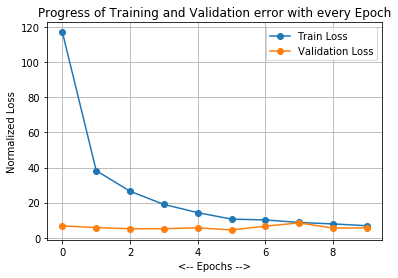

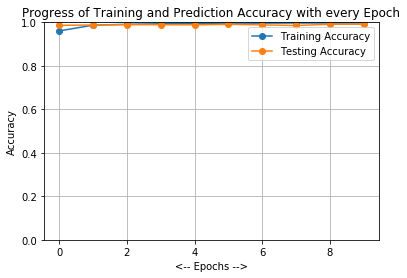

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      1.00      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



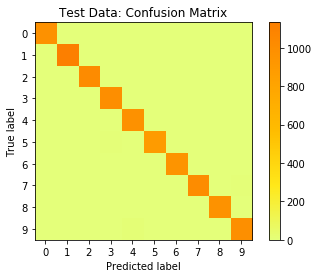

In [199]:
train_loss,test_loss,train_acc,test_acc = Run_CNN()

  0%|▏                                                                                 | 2/938 [00:00<00:58, 16.04it/s]

Epoch  1  has just begun!
******************  0.1  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.65it/s]


Train loss for Epoch  1 :  tensor(87.3512, grad_fn=<AddBackward0>)
Train accuracy for Epoch  1 :  0.9722666666666666


  0%|▏                                                                                 | 2/938 [00:00<00:54, 17.29it/s]

Test loss for Epoch  1 :  tensor(6.5476)
Test accuracy for Epoch  1 :  0.986
Epoch  2  has just begun!
******************  0.2  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:57<00:00, 16.28it/s]


Train loss for Epoch  2 :  tensor(41.6552, grad_fn=<AddBackward0>)
Train accuracy for Epoch  2 :  0.9862833333333333


  0%|▏                                                                                 | 2/938 [00:00<00:53, 17.34it/s]

Test loss for Epoch  2 :  tensor(5.1029)
Test accuracy for Epoch  2 :  0.9889
Epoch  3  has just begun!
******************  0.3  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:02<00:00, 14.99it/s]


Train loss for Epoch  3 :  tensor(30.3688, grad_fn=<AddBackward0>)
Train accuracy for Epoch  3 :  0.9900666666666667


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Test loss for Epoch  3 :  tensor(5.9035)
Test accuracy for Epoch  3 :  0.9876
Epoch  4  has just begun!
******************  0.4  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:59<00:00, 15.68it/s]


Train loss for Epoch  4 :  tensor(23.0978, grad_fn=<AddBackward0>)
Train accuracy for Epoch  4 :  0.9920333333333333


  0%|▏                                                                                 | 2/938 [00:00<01:12, 12.87it/s]

Test loss for Epoch  4 :  tensor(4.4334)
Test accuracy for Epoch  4 :  0.9891
Epoch  5  has just begun!
******************  0.5  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:58<00:00, 16.02it/s]


Train loss for Epoch  5 :  tensor(16.9564, grad_fn=<AddBackward0>)
Train accuracy for Epoch  5 :  0.994


  0%|▏                                                                                 | 2/938 [00:00<01:00, 15.36it/s]

Test loss for Epoch  5 :  tensor(4.9033)
Test accuracy for Epoch  5 :  0.9901
Epoch  6  has just begun!
******************  0.6  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:02<00:00, 15.12it/s]


Train loss for Epoch  6 :  tensor(14.9022, grad_fn=<AddBackward0>)
Train accuracy for Epoch  6 :  0.9951666666666666


  0%|▏                                                                                 | 2/938 [00:00<01:13, 12.73it/s]

Test loss for Epoch  6 :  tensor(5.2363)
Test accuracy for Epoch  6 :  0.9895
Epoch  7  has just begun!
******************  0.7  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:04<00:00, 14.60it/s]


Train loss for Epoch  7 :  tensor(12.2705, grad_fn=<AddBackward0>)
Train accuracy for Epoch  7 :  0.9957333333333334


  0%|▏                                                                                 | 2/938 [00:00<00:59, 15.72it/s]

Test loss for Epoch  7 :  tensor(7.8197)
Test accuracy for Epoch  7 :  0.985
Epoch  8  has just begun!
******************  0.8  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:58<00:00, 16.07it/s]


Train loss for Epoch  8 :  tensor(12.1311, grad_fn=<AddBackward0>)
Train accuracy for Epoch  8 :  0.9954


  0%|▏                                                                                 | 2/938 [00:00<00:56, 16.46it/s]

Test loss for Epoch  8 :  tensor(4.9920)
Test accuracy for Epoch  8 :  0.9902
Epoch  9  has just begun!
******************  0.9  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:04<00:00, 14.46it/s]


Train loss for Epoch  9 :  tensor(8.0159, grad_fn=<AddBackward0>)
Train accuracy for Epoch  9 :  0.9971166666666667


  0%|                                                                                  | 1/938 [00:00<01:38,  9.48it/s]

Test loss for Epoch  9 :  tensor(6.6000)
Test accuracy for Epoch  9 :  0.9891
Epoch  10  has just begun!
******************  1.0  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [01:23<00:00, 11.23it/s]


Train loss for Epoch  10 :  tensor(8.1213, grad_fn=<AddBackward0>)
Train accuracy for Epoch  10 :  0.9970833333333333
Test loss for Epoch  10 :  tensor(6.1793)
Test accuracy for Epoch  10 :  0.9896
Time taken to train and test model:  665.0661766529083


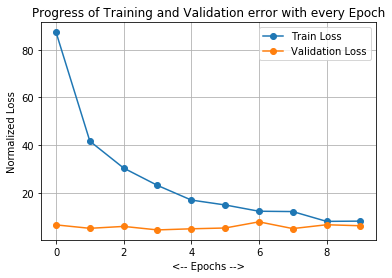

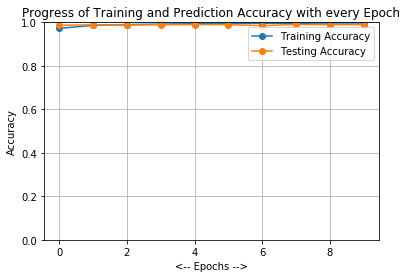

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      1.00      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.98      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.98      1.00      0.99       974
    9 - nine       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



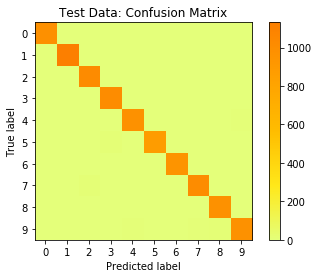

In [9]:
#Make the Batch_Norm flag true to run the below CNN with Batch Normalization
train_loss_1,test_loss_1,train_acc_1,test_acc_1 = Run_CNN()

  0%|                                                                                  | 1/938 [00:00<02:08,  7.30it/s]

Epoch  1  has just begun!
******************  0.1  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:45<00:00, 20.43it/s]


Train loss for Epoch  1 :  tensor(84.1827, grad_fn=<AddBackward0>)
Train accuracy for Epoch  1 :  0.97305


  0%|▎                                                                                 | 3/938 [00:00<00:45, 20.76it/s]

Test loss for Epoch  1 :  tensor(6.7989)
Test accuracy for Epoch  1 :  0.9858
Epoch  2  has just begun!
******************  0.2  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.53it/s]


Train loss for Epoch  2 :  tensor(38.9984, grad_fn=<AddBackward0>)
Train accuracy for Epoch  2 :  0.9867166666666667


  0%|▏                                                                                 | 2/938 [00:00<00:49, 18.87it/s]

Test loss for Epoch  2 :  tensor(5.2149)
Test accuracy for Epoch  2 :  0.9889
Epoch  3  has just begun!
******************  0.3  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.40it/s]


Train loss for Epoch  3 :  tensor(29.1121, grad_fn=<AddBackward0>)
Train accuracy for Epoch  3 :  0.99015


  0%|▏                                                                                 | 2/938 [00:00<00:56, 16.68it/s]

Test loss for Epoch  3 :  tensor(4.9744)
Test accuracy for Epoch  3 :  0.9902
Epoch  4  has just begun!
******************  0.4  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:48<00:00, 19.16it/s]


Train loss for Epoch  4 :  tensor(24.1892, grad_fn=<AddBackward0>)
Train accuracy for Epoch  4 :  0.9920333333333333


  0%|▏                                                                                 | 2/938 [00:00<00:52, 17.92it/s]

Test loss for Epoch  4 :  tensor(5.2797)
Test accuracy for Epoch  4 :  0.9884
Epoch  5  has just begun!
******************  0.5  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.42it/s]


Train loss for Epoch  5 :  tensor(16.8606, grad_fn=<AddBackward0>)
Train accuracy for Epoch  5 :  0.99415


  0%|▏                                                                                 | 2/938 [00:00<00:51, 18.03it/s]

Test loss for Epoch  5 :  tensor(5.2683)
Test accuracy for Epoch  5 :  0.989
Epoch  6  has just begun!
******************  0.6  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.74it/s]


Train loss for Epoch  6 :  tensor(13.9786, grad_fn=<AddBackward0>)
Train accuracy for Epoch  6 :  0.9949333333333333


  0%|▎                                                                                 | 3/938 [00:00<00:49, 18.89it/s]

Test loss for Epoch  6 :  tensor(7.2885)
Test accuracy for Epoch  6 :  0.9891
Epoch  7  has just begun!
******************  0.7  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.61it/s]


Train loss for Epoch  7 :  tensor(10.9676, grad_fn=<AddBackward0>)
Train accuracy for Epoch  7 :  0.9961333333333333


  0%|▏                                                                                 | 2/938 [00:00<00:48, 19.49it/s]

Test loss for Epoch  7 :  tensor(5.0255)
Test accuracy for Epoch  7 :  0.9915
Epoch  8  has just begun!
******************  0.8  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.55it/s]


Train loss for Epoch  8 :  tensor(10.8901, grad_fn=<AddBackward0>)
Train accuracy for Epoch  8 :  0.9962


  0%|▏                                                                                 | 2/938 [00:00<00:53, 17.57it/s]

Test loss for Epoch  8 :  tensor(5.5902)
Test accuracy for Epoch  8 :  0.9905
Epoch  9  has just begun!
******************  0.9  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:56<00:00, 16.63it/s]


Train loss for Epoch  9 :  tensor(8.4175, grad_fn=<AddBackward0>)
Train accuracy for Epoch  9 :  0.9970833333333333


  0%|▏                                                                                 | 2/938 [00:00<00:56, 16.44it/s]

Test loss for Epoch  9 :  tensor(5.3289)
Test accuracy for Epoch  9 :  0.9908
Epoch  10  has just begun!
******************  1.0  % ******************


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:54<00:00, 17.28it/s]


Train loss for Epoch  10 :  tensor(7.1424, grad_fn=<AddBackward0>)
Train accuracy for Epoch  10 :  0.99745
Test loss for Epoch  10 :  tensor(6.5438)
Test accuracy for Epoch  10 :  0.9909
Time taken to train and test model:  542.0460834503174
Average prediction accuracy across epochs:  0.9895099999999999
Average training accuracy across epochs:  0.99179


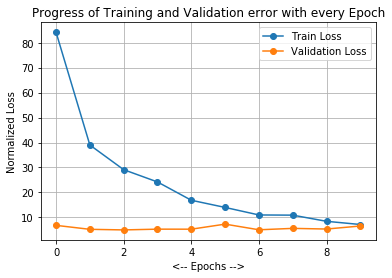

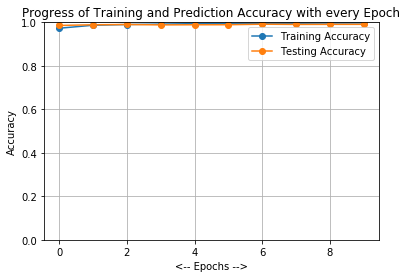

              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      1.00      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.98      0.99      0.99       892
     6 - six       1.00      0.98      0.99       958
   7 - seven       1.00      0.98      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



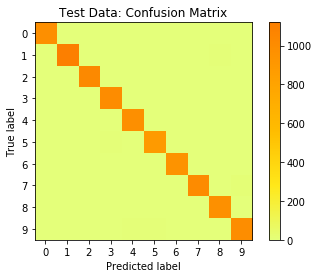

In [193]:
train_loss_1,test_loss_1,train_acc_1,test_acc_1 = Run_CNN()

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


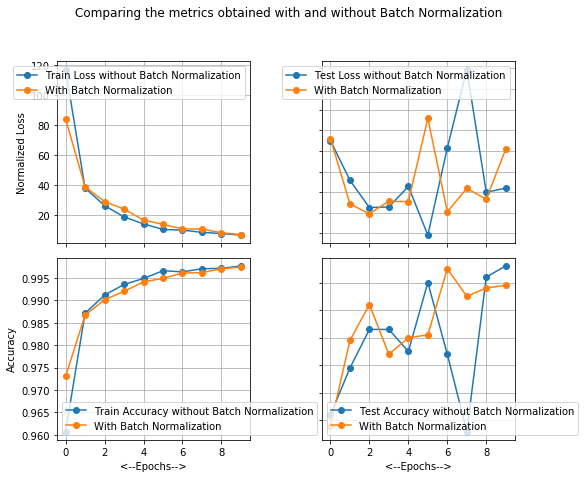

In [202]:
#comparing the accuracy metrics between the Batch Normalization and the non Batch Normalized networks

fig, axs = plt.subplots(2, 2,figsize = (8,6))
axs[0, 0].plot(train_loss,'o-',label = 'Train Loss without Batch Normalization')
axs[0, 0].plot(train_loss_1,'o-',label = 'With Batch Normalization' )
axs[0, 0].grid()
axs[0, 0].legend()
axs[0, 0].set_ylabel('Normalized Loss')
axs[0, 1].plot(test_loss,'o-',label = 'Test Loss without Batch Normalization')
axs[0, 1].plot(test_loss_1,'o-',label = 'With Batch Normalization' )
axs[0, 1].grid()
axs[0, 1].legend()
axs[1, 0].plot(train_acc,'o-',label = 'Train Accuracy without Batch Normalization')
axs[1, 0].plot(train_acc_1,'o-',label = 'With Batch Normalization' )
axs[1, 0].grid()
axs[1, 0].legend()
axs[1, 0].set_ylabel('Accuracy')
axs[1, 1].plot(test_acc,'o-',label = 'Test Accuracy without Batch Normalization')
axs[1, 1].plot(test_acc_1,'o-',label = 'With Batch Normalization' )
axs[1, 1].grid()
axs[1, 1].legend()


for ax in axs.flat:
    ax.set(xlabel='<--Epochs-->')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Comparing the metrics obtained with and without Batch Normalization ",x = 0.5,y=1.1)
fig.tight_layout()
fig.show()



C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


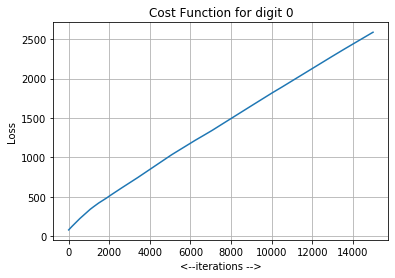

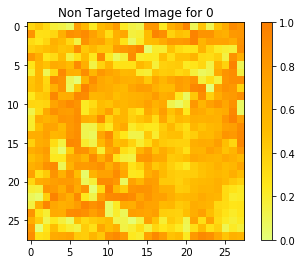

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


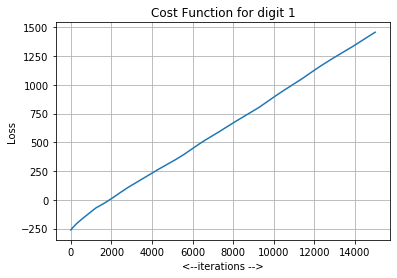

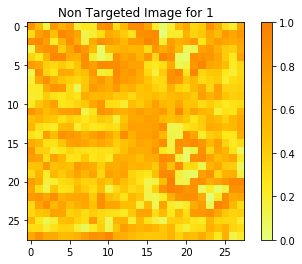

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


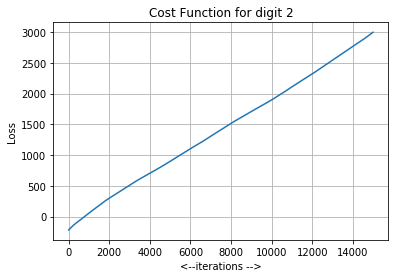

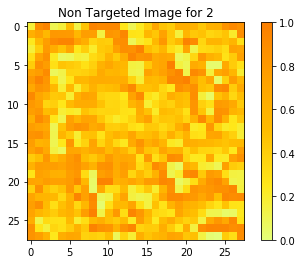

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


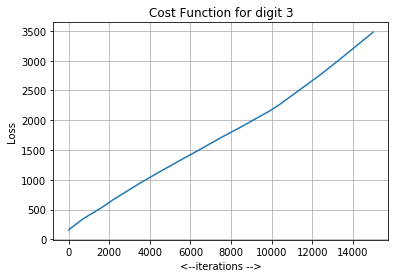

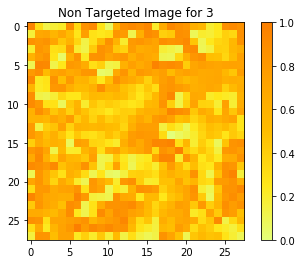

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


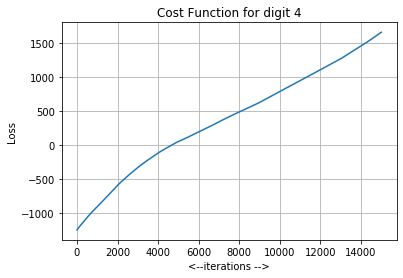

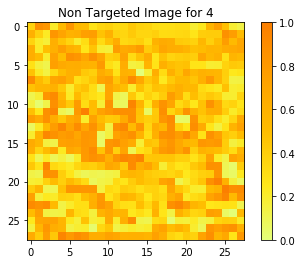

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


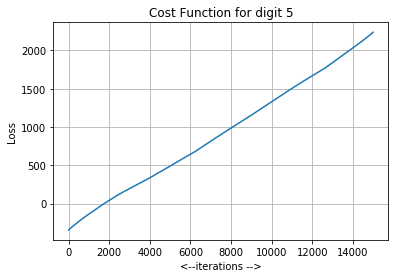

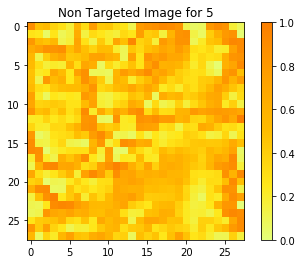

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


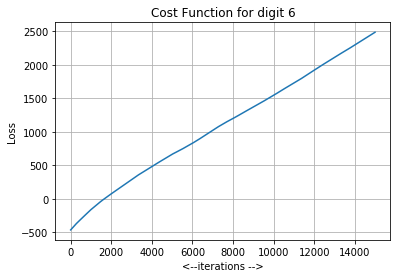

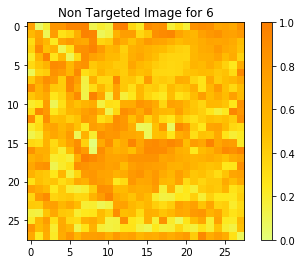

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


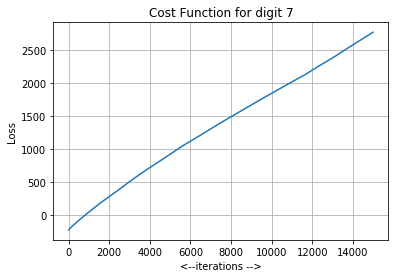

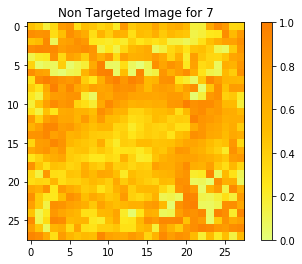

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


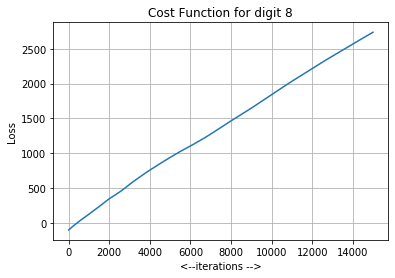

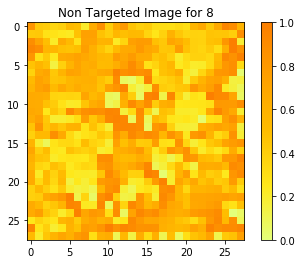

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:335: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


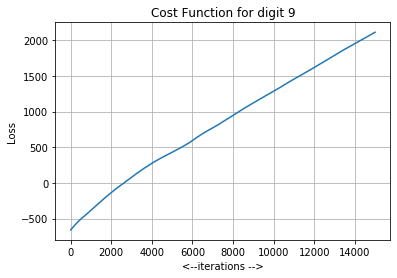

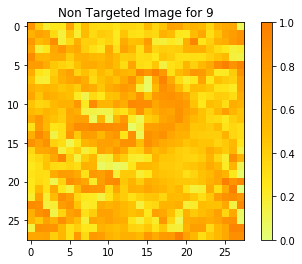

In [231]:
Run_CNN()

Enter the digit you'd want the generated image to look like1
What digit would you want this image to be recognized as?1


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:411: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Confidence in prediction: [0.]


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:462: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


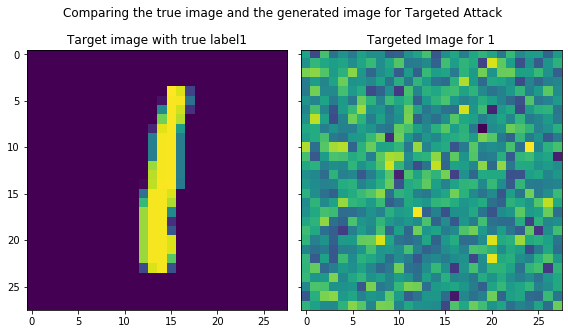

In [251]:
Run_CNN()

C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:304: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


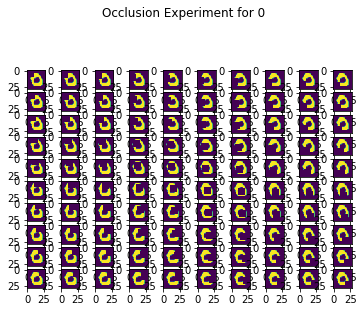

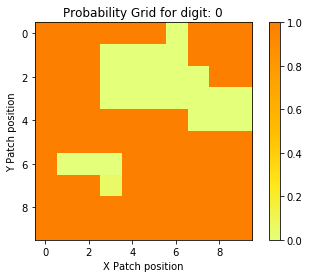

[[0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 3. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 7. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0. 0. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 6. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


<Figure size 432x288 with 0 Axes>

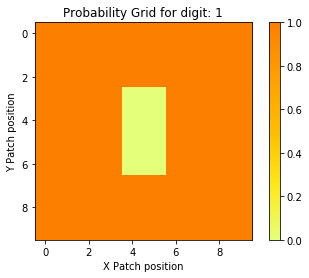

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 3. 3. 1. 1. 1. 1.]
 [1. 1. 1. 1. 5. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 5. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 5. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


<Figure size 432x288 with 0 Axes>

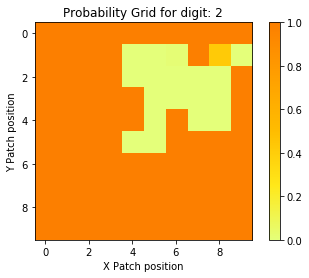

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 3. 3. 3. 2. 3. 7.]
 [2. 2. 2. 2. 3. 3. 7. 7. 7. 2.]
 [2. 2. 2. 2. 2. 7. 7. 7. 7. 2.]
 [2. 2. 2. 2. 2. 7. 2. 3. 3. 2.]
 [2. 2. 2. 2. 1. 7. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


<Figure size 432x288 with 0 Axes>

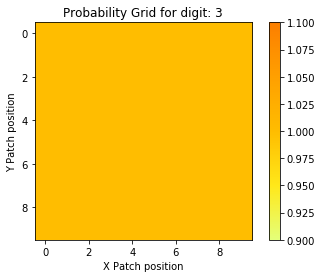

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


<Figure size 432x288 with 0 Axes>

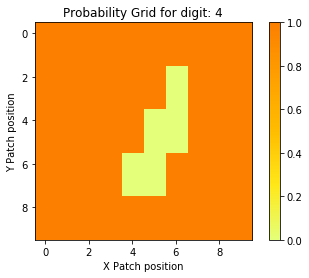

[[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 7. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 7. 4. 4. 4.]
 [4. 4. 4. 4. 4. 7. 7. 4. 4. 4.]
 [4. 4. 4. 4. 4. 5. 5. 4. 4. 4.]
 [4. 4. 4. 4. 5. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 5. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]]


<Figure size 432x288 with 0 Axes>

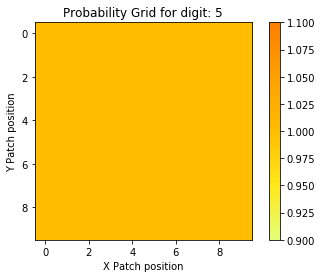

[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]


<Figure size 432x288 with 0 Axes>

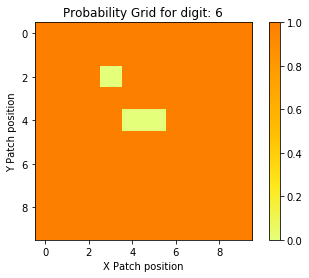

[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 2. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 3. 5. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]]


<Figure size 432x288 with 0 Axes>

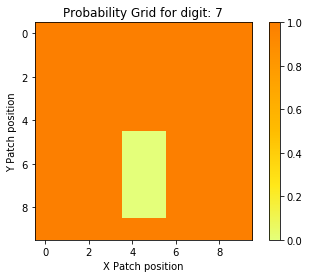

[[7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 9. 9. 7. 7. 7. 7.]
 [7. 7. 7. 7. 9. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 9. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 5. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]]


<Figure size 432x288 with 0 Axes>

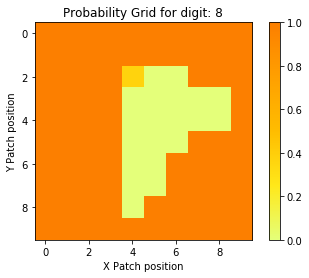

[[8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 2. 3. 3. 8. 8. 8.]
 [8. 8. 8. 8. 3. 3. 3. 3. 9. 8.]
 [8. 8. 8. 8. 3. 3. 3. 3. 9. 8.]
 [8. 8. 8. 8. 3. 3. 3. 8. 8. 8.]
 [8. 8. 8. 8. 5. 5. 8. 8. 8. 8.]
 [8. 8. 8. 8. 5. 5. 8. 8. 8. 8.]
 [8. 8. 8. 8. 5. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]]


<Figure size 432x288 with 0 Axes>

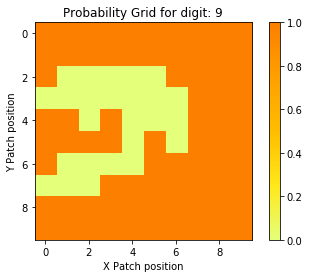

[[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 4. 4. 1. 1. 7. 9. 9. 9. 9.]
 [4. 4. 4. 7. 7. 7. 7. 9. 9. 9.]
 [9. 9. 7. 9. 7. 7. 3. 9. 9. 9.]
 [9. 9. 9. 9. 7. 9. 5. 9. 9. 9.]
 [9. 4. 4. 4. 5. 9. 9. 9. 9. 9.]
 [4. 4. 4. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]


In [254]:
Run_CNN()

Enter the digit you'd want the generated image to look like6
What digit would you want this image to be recognized as?8


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:410: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


8
Confidence in prediction: [1.]


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:461: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


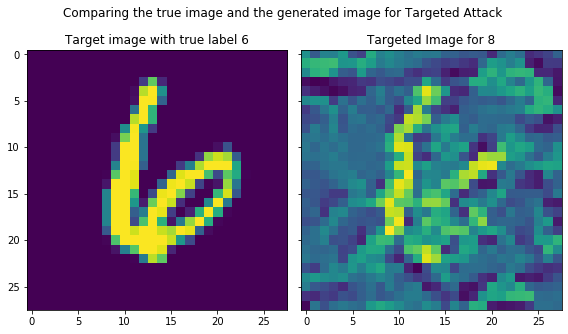

In [292]:
Run_CNN()

Enter the digit you'd want the generated image to look like2
What digit would you want this image to be recognized as?3


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:493: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predicted Class:  3
Confidence in prediction: [1.]
Enter the digit you'd want to add the noise matrix to4
Predicted Class:  4
Confidence in prediction: [0.]


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:584: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


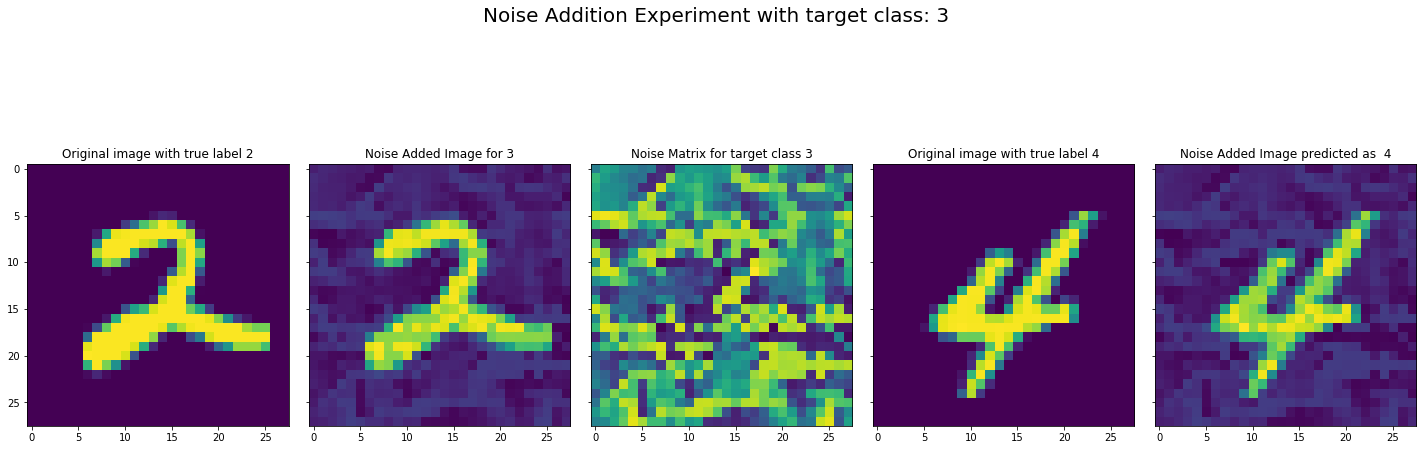

In [310]:
Run_CNN()

Do you wanna observe the plots of random test images and their corresponded predicted labels? (y/n)y
6003


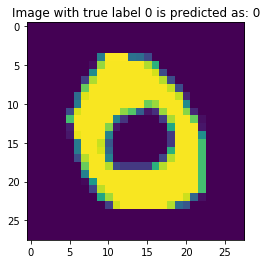

416


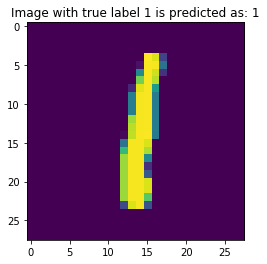

6754


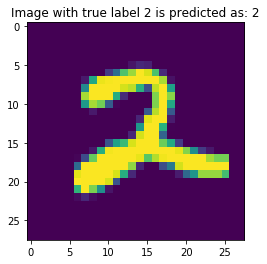

1605


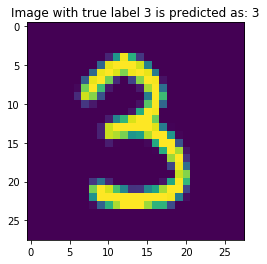

5055


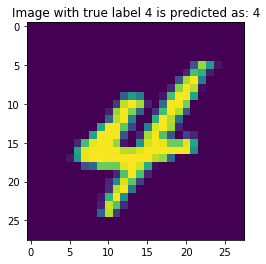

7965


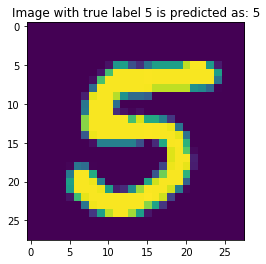

517


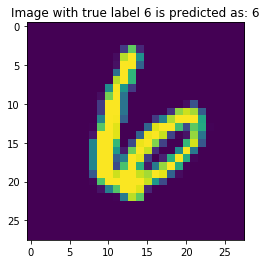

5551


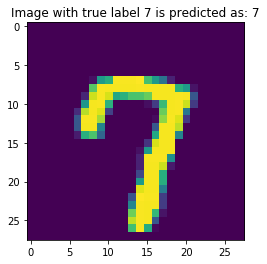

7070


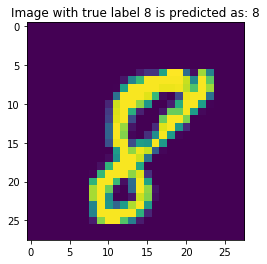

6420


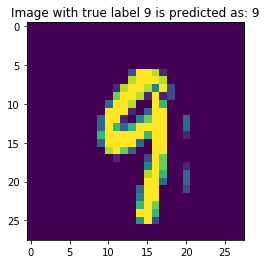

Do you wanna observe the plots of the filters in the convolutional layers? (y/n)n
Do you wanna observe the plots of the activation functions of the convolutional layers? (y/n)n
Do you wanna partake in an occlusion experiment? (y/n)n
Do you wanna orchestrate a non targeted adversarial attack? (y/n)n
Do you wanna orchestrate a targeted adversarial attack? (y/n)n
Do you wanna orchestrate a noise addition based adversarial attack? (y/n)n


In [318]:
Run_CNN()

Do you wanna observe the plots of random test images and their corresponded predicted labels? (y/n)n
Do you wanna observe the plots of the filters in the convolutional layers? (y/n)y


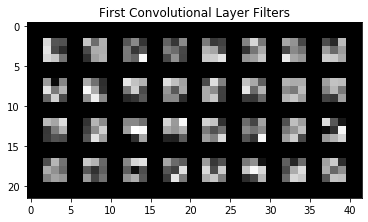

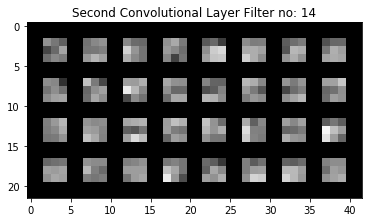

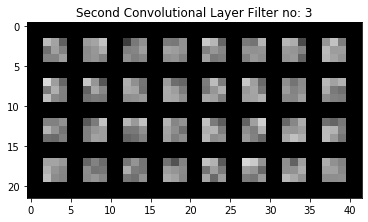

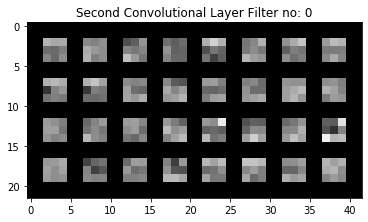

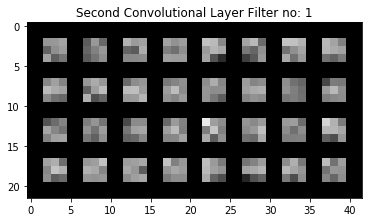

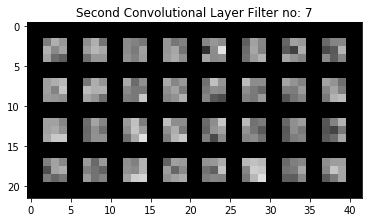

Do you wanna observe the plots of the activation functions of the convolutional layers? (y/n)y


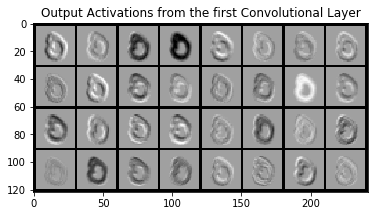

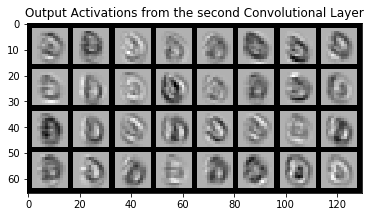

Do you wanna partake in an occlusion experiment? (y/n)y


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:304: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


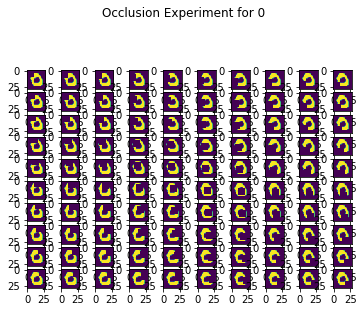

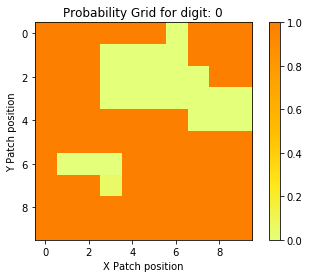

[[0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 3. 2. 2. 0. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 7. 0. 0.]
 [0. 0. 0. 2. 2. 2. 2. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0. 0. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 6. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


<Figure size 432x288 with 0 Axes>

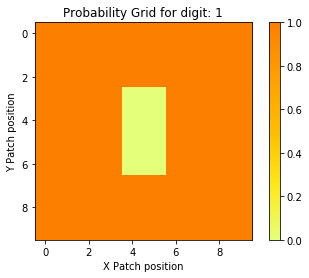

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 3. 3. 1. 1. 1. 1.]
 [1. 1. 1. 1. 5. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 5. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 5. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


<Figure size 432x288 with 0 Axes>

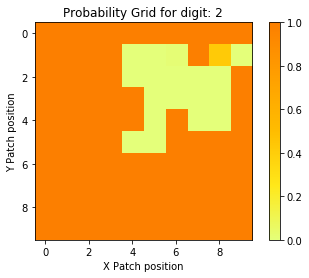

[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 3. 3. 3. 2. 3. 7.]
 [2. 2. 2. 2. 3. 3. 7. 7. 7. 2.]
 [2. 2. 2. 2. 2. 7. 7. 7. 7. 2.]
 [2. 2. 2. 2. 2. 7. 2. 3. 3. 2.]
 [2. 2. 2. 2. 1. 7. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]


<Figure size 432x288 with 0 Axes>

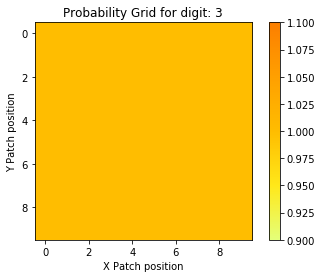

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


<Figure size 432x288 with 0 Axes>

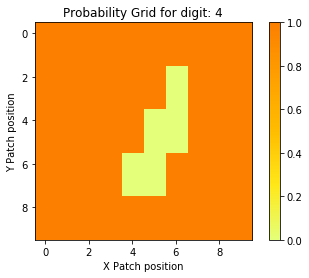

[[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 7. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 7. 4. 4. 4.]
 [4. 4. 4. 4. 4. 7. 7. 4. 4. 4.]
 [4. 4. 4. 4. 4. 5. 5. 4. 4. 4.]
 [4. 4. 4. 4. 5. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 5. 5. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]]


<Figure size 432x288 with 0 Axes>

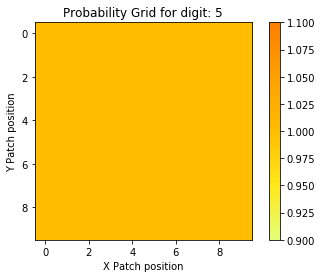

[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]


<Figure size 432x288 with 0 Axes>

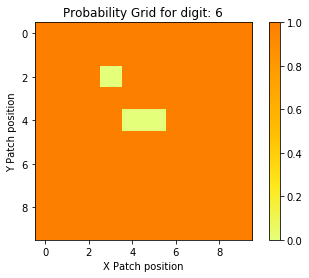

[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 2. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 3. 5. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]]


<Figure size 432x288 with 0 Axes>

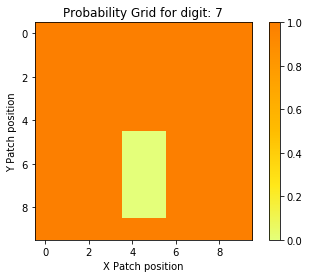

[[7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 9. 9. 7. 7. 7. 7.]
 [7. 7. 7. 7. 9. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 9. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 5. 5. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]]


<Figure size 432x288 with 0 Axes>

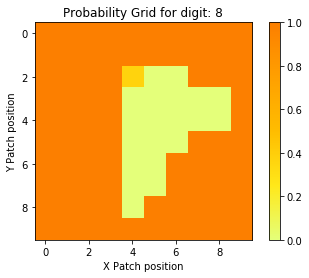

[[8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 2. 3. 3. 8. 8. 8.]
 [8. 8. 8. 8. 3. 3. 3. 3. 9. 8.]
 [8. 8. 8. 8. 3. 3. 3. 3. 9. 8.]
 [8. 8. 8. 8. 3. 3. 3. 8. 8. 8.]
 [8. 8. 8. 8. 5. 5. 8. 8. 8. 8.]
 [8. 8. 8. 8. 5. 5. 8. 8. 8. 8.]
 [8. 8. 8. 8. 5. 8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]]


<Figure size 432x288 with 0 Axes>

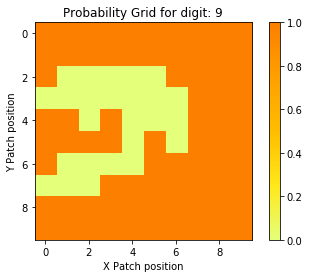

[[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 4. 4. 1. 1. 7. 9. 9. 9. 9.]
 [4. 4. 4. 7. 7. 7. 7. 9. 9. 9.]
 [9. 9. 7. 9. 7. 7. 3. 9. 9. 9.]
 [9. 9. 9. 9. 7. 9. 5. 9. 9. 9.]
 [9. 4. 4. 4. 5. 9. 9. 9. 9. 9.]
 [4. 4. 4. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]
Do you wanna orchestrate a non targeted adversarial attack? (y/n)n
Do you wanna orchestrate a targeted adversarial attack? (y/n)n
Do you wanna orchestrate a noise addition based adversarial attack? (y/n)n


In [319]:
Run_CNN()

Do you wanna observe the plots of random test images and their corresponded predicted labels? (y/n)n
Do you wanna observe the plots of the filters in the convolutional layers? (y/n)n
Do you wanna observe the plots of the activation functions of the convolutional layers? (y/n)n
Do you wanna partake in an occlusion experiment? (y/n)n
Do you wanna orchestrate a non targeted adversarial attack? (y/n)n
Do you wanna orchestrate a targeted adversarial attack? (y/n)y
Enter the digit you'd want the generated image to look like0
What digit would you want this image to be recognized as?1


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:410: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:461: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


1
Confidence in prediction: [1.]
Do you wanna orchestrate a noise addition based adversarial attack? (y/n)y
Enter the digit you'd want the generated image to look like0
What digit would you want this image to be recognized as?1


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:493: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predicted Class:  1
Confidence in prediction: [1.]
Enter the digit you'd want to add the noise matrix to7
Predicted Class:  7
Confidence in prediction: [0.]


C:\Users\ABHISHEK\anaconda3\lib\site-packages\ipykernel_launcher.py:584: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


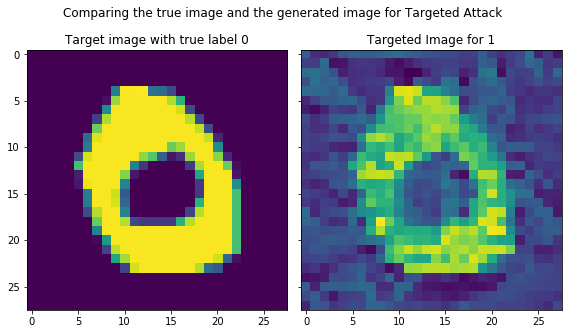

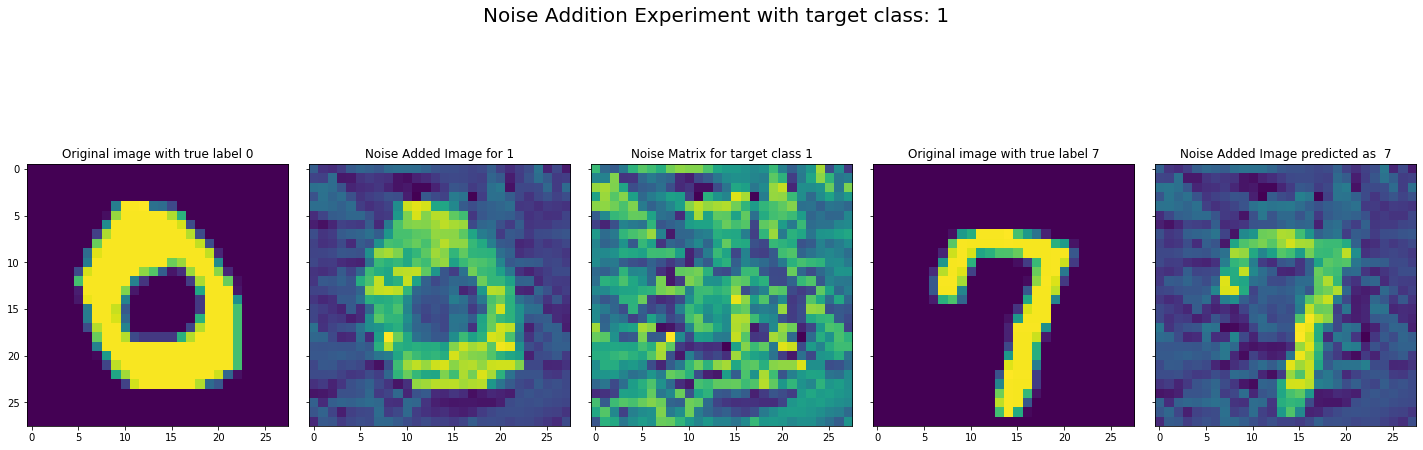

In [353]:
Run_CNN()